# Chrome Dino Game AI Model

---

## Setup:

In [ ]:
!pip3 install torch torchvision torchaudio

In [ ]:
!pip install stable-baselines[extra] protobuf==3.20.*

In [ ]:
!pip install mss pydirectinput pytesseract

In [7]:
pytesseract.pytesseract.tesseract_cmd = r"Tesseract-OCR/tesseract.exe"

In [1]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete

## 2. Bulid Env

In [2]:
class WebGame(Env):
    # Setup Env
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.done_location = {'top': 405, 'left': 630, 'width': 660, 'height': 70}
    
    
    # What is called to do something in game
    def step(self, action):
        action_map = {
            0:'space',
            1: 'down', 
            2: 'no_op'
        }
        if action !=2:
            pydirectinput.press(action_map[action])

        done, done_cap = self.get_done() 
        observation = self.get_observation()
        reward = 1 
        info = {}
        return observation, reward, done, info
        
    # Visualize the game
    def render(self):
        cv2.imshow("Game", self.cap(self.current_frame))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    
    # Reset the Game
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation()
    
    
    # Closes the observation
    def close(self):
        cv2.destroyAllWindows()
    
    # Get part of the observation of the game we want
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
    

    # Get the DOne text
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['GAME', 'GAHE']
        done=False
        # if np.sum(done_cap) < 44300000:
        #     done = True
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

In [3]:
env = WebGame()

In [4]:
obs=env.get_observation()

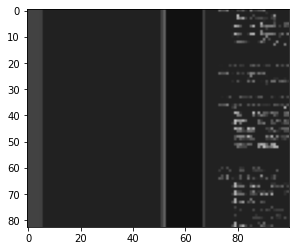

In [5]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

In [8]:
done, done_cap = env.get_done()

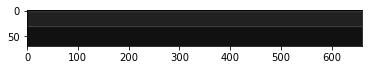

In [9]:
plt.imshow(done_cap)

In [10]:
done

False

## 3. Model

### Create Callback

In [ ]:
!pip install stable_baselines3

In [ ]:
!pip install stable-baselines3[extra] protobuf==3.20.*

In [11]:
import gym

In [12]:
!pip install gym==0.21.0

In [14]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [13]:
print(gym.__version__)

0.21.0


In [24]:
env_checker.check_env(env)

### Bulid DQN & Train

In [16]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [17]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [18]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

### Train

In [20]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [21]:
env = WebGame()

In [23]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=120000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [25]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11       |
|    ep_rew_mean      | 11       |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 26       |
|    total_timesteps  | 44       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.6     |
|    ep_rew_mean      | 12.6     |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 52       |
|    total_timesteps  | 101      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.8     |
|    ep_rew_mean      | 13.8     |
|    exploration_rate | 0.984    |
| time/               |        

KeyboardInterrupt: 

## 4. Test Model

In [ ]:
model.load('train_first/best_mode l_50000') 

In [ ]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)